# TEAM-KMJS (a.k.a Team Sasa)     
### Sprint4 - News 

In [26]:
import spacy
import en_core_web_lg, en_core_web_sm, en_core_web_md

import gensim 
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.summarization.summarizer import summarize

import pyLDAvis.gensim

import numpy as np 
import pandas as pd
import math 

import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob 
# https://www.loc.gov/standards/iso639-2/php/code_list.php

import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

from collections import  Counter
import string, os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gear\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gear\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gear\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
print(f'SpaCy:\t{spacy.__version__}')
print(f'en_core_web_lg:\t{en_core_web_lg.__version__}')
print(f'NLTK:\t{nltk.__version__}')
print(f'gensim:\t{gensim.__version__}')

SpaCy:	3.0.5
en_core_web_lg:	3.0.0
NLTK:	3.5
gensim:	3.8.3


In [28]:

### NLP Model
# NLP = en_core_web_lg.load()
NLP = spacy.load('en_core_web_lg', disable=['parser', 'ner'])


### Stop Words
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['news', 'advertisement', 'rappler', 'gma', 'inquirer', 'manila', 'philippines', 'philippine', 'bulletin', 'star',\
    'cnn', 'abs', 'cbn', 'abscbn', 'abs-cbn', 'sunstar', 'covid', 'covid-19', 'covid19', 'vaccine', 'say'])
#                  'also', 'city', 'country', 'dose', 'first', 'government', 'health', 'vaccination'])
TAGALOG = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ii
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

STOPWORDS.extend(TAGALOG)
print(STOPWORDS)

### Doc Object
def get_doc(text):
    docstring =  str(''.join([i if ord(i) < 128 else ' ' for i in text]))
    return NLP(docstring)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [29]:
FILENAME = 'datasets/combined_and_cleaned_randomsampled_less.csv'

df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              581 non-null    object
 1   titles            581 non-null    object
 2   authors           581 non-null    object
 3   published_dates   581 non-null    object
 4   articles_content  581 non-null    object
 5   news_org          581 non-null    object
 6   dates             581 non-null    object
dtypes: object(7)
memory usage: 31.9+ KB


,urls,titles,authors,published_dates,articles_content,news_org,dates
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\r\nThe Philippine governme...",Rappler,2021-02-18 09:22:00
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\r\n(UPDATED) On March 1, t...",Rappler,2021-02-04 19:43:00
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\r\n(UPDATED) Malacañang sa...",Rappler,2021-03-03 14:41:00
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\r\n(UPDATED) Its lower eff...",Rappler,2021-02-22 12:19:00
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\r\n(3rd UPDATE) The arriva...",Rappler,2021-02-28 16:16:00
...,...,...,...,...,...,...,...
576,https://newsinfo.inquirer.net/1390868/up-to-10...,Up to 108 million Covid-19 vaccine doses alrea...,Krissy Aguilar,"12:11 AM February 02, 2021","MANILA, Philippines — The Philippines has so f...",Inquirer,2021-02-02 00:11:00
577,https://newsinfo.inquirer.net/1399844/only-19-...,46% of adult Filipinos unwilling to get COVID-...,Gabriel Pabico Lalu,"12:58 AM February 25, 2021","MANILA, Philippines —Only 19 percent of adult ...",Inquirer,2021-02-25 00:58:00
578,https://newsinfo.inquirer.net/1377859/pfizers-...,Pfizer’s COVID-19 vaccine expected to get EUA ...,Katrina Hallare,"09:42 AM December 31, 2020","(Photo by JOEL SAGET / AFP)\nMANILA, Philippin...",Inquirer,2020-12-31 09:42:00
579,https://newsinfo.inquirer.net/1381899/ph-secur...,PH secures deal for 30M doses of Covovax COVID...,Darryl John Esguerra,"07:05 PM January 10, 2021","MANILA, Philippines — The Philippines has sign...",Inquirer,2021-01-10 19:05:00


# TOPIC MODELING
### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Tokenize words and Clean-up text


In [30]:
# Convert to list
data = df['titles'].values.tolist()

# Convert R&D to Research and Development
data = [sent.lower().replace('r&d', 'Research and Development') for sent in data]

# Remove URLs
data = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", '', sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list(sent_to_words(data))
print(data[:1])


[['here', 'why', 'covid', 'vaccines', 'haven', 'arrived', 'in', 'the', 'philippines', 'yet']]


## Text Summrization

In [31]:
NUM_SENTENCES = 7

def build_summary(text):
    parser = PlaintextParser.from_string(text, Tokenizer('english'))
    lexranksummarizer = LexRankSummarizer()
    summary = lexranksummarizer(parser.document, sentences_count=NUM_SENTENCES)
    # print(f'\n\n1\t{ret[0]}')
    # print(f'2\t{ret[1]}')
    # print(f'7\t{ret[1]}')
    summary_text = ''
    for s in summary:
        summary_text += str(s)
    # print (summary_text)
    return summary_text
    
df['articles_summary'] = df['articles_content'].apply(build_summary)
print(df[['articles_content','articles_summary']].isna().sum())
df[['articles_content','articles_summary']]

articles_content    0
articles_summary    0
dtype: int64


,articles_content,articles_summary
0,"MANILA, PHILIPPINES\r\nThe Philippine governme...",Why do we need an indemnification fund?An inde...
1,"MANILA, PHILIPPINES\r\n(UPDATED) On March 1, t...","Now, the Philippines is just weeks away from s..."
2,"MANILA, PHILIPPINES\r\n(UPDATED) Malacañang sa...","(UPDATED) Malacañang says 487,200 doses from t..."
3,"MANILA, PHILIPPINES\r\n(UPDATED) Its lower eff...",FDA Director General Eric Domingo made the ann...
4,"MANILA, PHILIPPINES\r\n(3rd UPDATE) The arriva...",(3rd UPDATE) The arrival of donated COVID-19 v...
...,...,...
576,"MANILA, Philippines — The Philippines has so f...","MANILA, Philippines — The Philippines has so f..."
577,"MANILA, Philippines —Only 19 percent of adult ...",This is the finding of a survey done by OCTA R...
578,"(Photo by JOEL SAGET / AFP)\nMANILA, Philippin...","(Photo by JOEL SAGET / AFP) MANILA, Philippine..."
579,"MANILA, Philippines — The Philippines has sign...","MANILA, Philippines — The Philippines has sign..."


## Creating Bigram and Trigram Models

In [32]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

['here', 'why', 'covid', 'vaccines', 'haven', 'arrived', 'in', 'the', 'philippines', 'yet']


## Remove Stopwords, Make Bigrams and Lemmatize


In [33]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = NLP(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [34]:
# Do lemmatization keeping only noun, adj, vb, adv
data = lemmatization(data)

# Remove Stop Words
data = remove_stopwords(data)
# data = remove_stopwords(data)
# data = remove_stopwords(data)

# Form Bigrams | Trigrams
data = make_bigrams(data)

#### NOTE: lemmatization was move to first pass
# # Do lemmatization keeping only noun, adj, vb, adv
# data = lemmatization(data)

print(data[:1])

[['arrive', 'yet']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [35]:
# Create Dictionary
id2word_dictionary = Dictionary(data)

# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word_dictionary.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
# [(id2word_dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1)]]


## Building the Topic Model

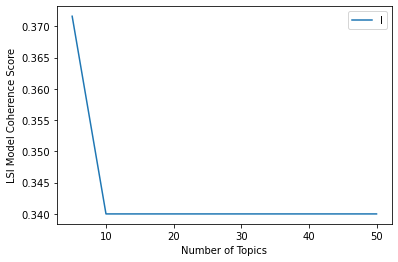


LSI coherence scores
LSI Model[0] ~> N-Topics ~>  5 has Coherence Value of ~> 0.3716
LSI Model[1] ~> N-Topics ~> 10 has Coherence Value of ~> 0.34
LSI Model[2] ~> N-Topics ~> 15 has Coherence Value of ~> 0.34
LSI Model[3] ~> N-Topics ~> 20 has Coherence Value of ~> 0.34
LSI Model[4] ~> N-Topics ~> 25 has Coherence Value of ~> 0.34
LSI Model[5] ~> N-Topics ~> 30 has Coherence Value of ~> 0.34
LSI Model[6] ~> N-Topics ~> 35 has Coherence Value of ~> 0.34
LSI Model[7] ~> N-Topics ~> 40 has Coherence Value of ~> 0.34
LSI Model[8] ~> N-Topics ~> 45 has Coherence Value of ~> 0.34
LSI Model[9] ~> N-Topics ~> 50 has Coherence Value of ~> 0.34





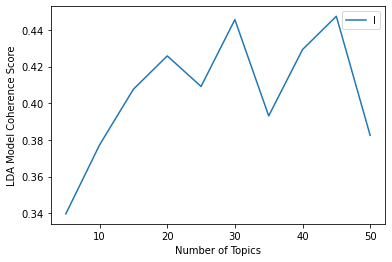



LDA coherence scores
LDA Model[0] ~> N-Topics ~>  5 has Coherence Value of ~> 0.3396
LDA Model[1] ~> N-Topics ~> 10 has Coherence Value of ~> 0.3773
LDA Model[2] ~> N-Topics ~> 15 has Coherence Value of ~> 0.4076
LDA Model[3] ~> N-Topics ~> 20 has Coherence Value of ~> 0.4258
LDA Model[4] ~> N-Topics ~> 25 has Coherence Value of ~> 0.4092
LDA Model[5] ~> N-Topics ~> 30 has Coherence Value of ~> 0.4456
LDA Model[6] ~> N-Topics ~> 35 has Coherence Value of ~> 0.3931
LDA Model[7] ~> N-Topics ~> 40 has Coherence Value of ~> 0.4293
LDA Model[8] ~> N-Topics ~> 45 has Coherence Value of ~> 0.4475
LDA Model[9] ~> N-Topics ~> 50 has Coherence Value of ~> 0.3825
Wall time: 54 s


In [36]:
%%time 

limit = 51; start = 5; step = 5
lsicoherences = []
lsimodels = []
ldacoherences = []
ldamodels = []

for N in range(start, limit, step):
    # LSI
    lsimodel = LsiModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary)
    lsimodels.append(lsimodel)
    lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
    lsicoherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    lsicoherences.append((lsicoherence))
    # LDA
    ldamodel = LdaModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary, random_state = 2)
    ldamodels.append(ldamodel)
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    ldacoherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    ldacoherences.append((ldacoherence))

# HDP
#hdpmodel = HdpModel(corpus=corpus, id2word=id2word_dictionary)
#hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
#hdpcoherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()


# Plot the number of topics based on LSI coherence score
x = range(start, limit, step)
plt.plot(x, lsicoherences)
plt.xlabel('Number of Topics')
plt.ylabel('LSI Model Coherence Score')
plt.legend('lsicoherences', loc='best')
plt.show()  
# Print the LSI coherence scores
print('\nLSI coherence scores')
idx = 0
for n, cv in zip(x, lsicoherences):
    print(f'LSI Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

print('\n\n')

# Plot the number of topics based on LDA coherence score
x = range(start, limit, step)
plt.plot(x, ldacoherences)
plt.xlabel('Number of Topics')
plt.ylabel('LDA Model Coherence Score')
plt.legend('ldacoherences', loc='best')
plt.show()  
# Print the LDA coherence scores
print('\n\nLDA coherence scores')
idx = 0
for n, cv in zip(x, ldacoherences):
    print(f'LDA Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1


In [37]:
'''
def evaluate_coherence_bargraph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.3, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.title('Topic Model Performance')
    plt.show
    
evaluate_coherence_bargraph([lsicoherences[2], ldacoherences[2], hdpcoherence], ['LSI', 'LDA', 'HDP'])
'''

"\ndef evaluate_coherence_bargraph(coherences, indices):\n    assert len(coherences) == len(indices)\n    n = len(coherences)\n    x = np.arange(n)\n    plt.bar(x, coherences, width=0.3, tick_label=indices, align='center')\n    plt.xlabel('Models')\n    plt.ylabel('Coherence Value')\n    plt.title('Topic Model Performance')\n    plt.show\n    \nevaluate_coherence_bargraph([lsicoherences[2], ldacoherences[2], hdpcoherence], ['LSI', 'LDA', 'HDP'])\n"

In [38]:
# INTENTIONAL EXCEPTION
#raise Exception('Select the BEST MODELS')

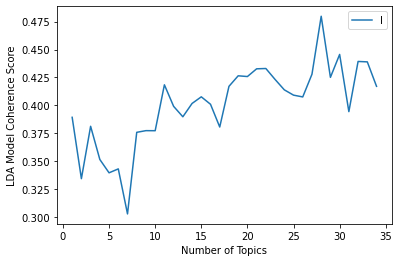



LDA coherence scores
LDA Model[0] ~> N-Topics ~>  1 has Coherence Value of ~> 0.3893
LDA Model[1] ~> N-Topics ~>  2 has Coherence Value of ~> 0.3343
LDA Model[2] ~> N-Topics ~>  3 has Coherence Value of ~> 0.3813
LDA Model[3] ~> N-Topics ~>  4 has Coherence Value of ~> 0.3515
LDA Model[4] ~> N-Topics ~>  5 has Coherence Value of ~> 0.3396
LDA Model[5] ~> N-Topics ~>  6 has Coherence Value of ~> 0.3431
LDA Model[6] ~> N-Topics ~>  7 has Coherence Value of ~> 0.3028
LDA Model[7] ~> N-Topics ~>  8 has Coherence Value of ~> 0.3759
LDA Model[8] ~> N-Topics ~>  9 has Coherence Value of ~> 0.3774
LDA Model[9] ~> N-Topics ~> 10 has Coherence Value of ~> 0.3773
LDA Model[10] ~> N-Topics ~> 11 has Coherence Value of ~> 0.4184
LDA Model[11] ~> N-Topics ~> 12 has Coherence Value of ~> 0.3991
LDA Model[12] ~> N-Topics ~> 13 has Coherence Value of ~> 0.3898
LDA Model[13] ~> N-Topics ~> 14 has Coherence Value of ~> 0.4017
LDA Model[14] ~> N-Topics ~> 15 has Coherence Value of ~> 0.4076
LDA Model[15

In [39]:
%%time 
#Narrowing it down, using what was identified above change the  limit, start and step, comment out the models that are not the best
limit = 35; start = 1; step = 1
lsicoherences = []
lsimodels = []
ldacoherences = []
ldamodels = []

for N in range(start, limit, step):
    # LSI
    #lsimodel = LsiModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary, random_state = 2)
    #lsimodels.append(lsimodel)
    #lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
    #lsicoherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    #lsicoherences.append((lsicoherence))
    # LDA
    ldamodel = LdaModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary, random_state = 2)
    ldamodels.append(ldamodel)
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    ldacoherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    ldacoherences.append((ldacoherence))

# HDP
#hdpmodel = HdpModel(corpus=corpus, id2word=id2word_dictionary)
#hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
#hdpcoherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()

'''
# Plot the number of topics based on LSI coherence score
x = range(start, limit, step)
plt.plot(x, lsicoherences)
plt.xlabel('Number of Topics')
plt.ylabel('LSI Model Coherence Score')
plt.legend('lsicoherences', loc='best')
plt.show()  
# Print the LSI coherence scores
print('\nLSI coherence scores')
idx = 0
for n, cv in zip(x, lsicoherences):
    print(f'LSI Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

print('\n\n')
'''

# Plot the number of topics based on LDA coherence score
x = range(start, limit, step)
plt.plot(x, ldacoherences)
plt.xlabel('Number of Topics')
plt.ylabel('LDA Model Coherence Score')
plt.legend('ldacoherences', loc='best')
plt.show()  
# Print the LDA coherence scores
print('\n\nLDA coherence scores')
idx = 0
for n, cv in zip(x, ldacoherences):
    print(f'LDA Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

In [40]:
# INTENTIONAL EXCEPTION
raise Exception('Select the BEST MODELS')

Exception: Select the BEST MODELS

In [41]:
# Select the BEST model and print the topics
# TODO: best_model = {lsi, lda, hdp}models[2]   e.g. best_model = ldamodels[2]

best_model = ldamodels[5]
topics = best_model.show_topics(formatted=False)
best_model.print_topics(num_words=15)

[(0,
  '0.014*"get" + 0.013*"ph" + 0.012*"moderna" + 0.012*"case" + 0.011*"china" + 0.010*"sinovac" + 0.009*"filipino" + 0.009*"duterte" + 0.009*"dose" + 0.009*"willing" + 0.007*"first" + 0.007*"fda" + 0.007*"arrive" + 0.007*"vaccinate" + 0.007*"give"'),
 (1,
  '0.020*"vaccination" + 0.016*"duterte" + 0.012*"expert" + 0.010*"trial" + 0.010*"get" + 0.010*"approve" + 0.010*"emergency_use" + 0.009*"first" + 0.009*"astrazeneca" + 0.009*"pfizer" + 0.007*"plan" + 0.007*"begin" + 0.007*"filipino" + 0.006*"procurement" + 0.006*"gov"'),
 (2,
  '0.019*"astrazeneca" + 0.014*"pfizer" + 0.013*"ph" + 0.010*"deal" + 0.010*"sign" + 0.009*"receive" + 0.008*"dose" + 0.008*"duterte" + 0.008*"trial" + 0.008*"roque" + 0.007*"get" + 0.007*"secure" + 0.007*"duque" + 0.007*"vaccinate" + 0.007*"buy"'),
 (3,
  '0.030*"dose" + 0.018*"duterte" + 0.016*"get" + 0.013*"arrive" + 0.012*"coronavirus" + 0.011*"astrazeneca" + 0.010*"pfizer" + 0.010*"first" + 0.010*"country" + 0.009*"palace" + 0.009*"ph" + 0.008*"trial" 

In [ ]:

# from collections import Counter
# import matplotlib.colors as mcolors


# data_flat = [w for w_list in data for w in w_list]
# counter = Counter(data_flat)

# out = []
# for i, topic in topics:
#     for word, weight in topic:
#         out.append([word, i , weight, counter[word]])

# dff = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# # Plot Word Count and Weights of Topic Keywords
# fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
# for i, ax in enumerate(axes.flatten()):
#     ax.bar(x='word', height="word_count", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
#     ax_twin = ax.twinx()
#     ax_twin.bar(x='word', height="importance", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
#     ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
#     ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
#     ax.tick_params(axis='y', left=False)
#     ax.set_xticklabels(dff.loc[dff.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
#     ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# fig.tight_layout(w_pad=2)    
# fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
# plt.show()
# dff

In [42]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_model, corpus, id2word_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.033180  0.052684       1        1  19.177680
5      0.031936 -0.135359       2        1  18.199309
3     -0.043575  0.018614       3        1  17.794535
1      0.113957  0.038349       4        1  16.207398
2     -0.045913  0.030204       5        1  14.609295
0     -0.089586 -0.004492       6        1  14.011784, topic_info=            Term       Freq      Total Category  logprob  loglift
436         city  18.000000  18.000000  Default  30.0000  30.0000
295  vaccination  31.000000  31.000000  Default  29.0000  29.0000
4    astrazeneca  28.000000  28.000000  Default  28.0000  28.0000
31        worker  15.000000  15.000000  Default  27.0000  27.0000
55          sign   5.000000   5.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
91         envoy   2.278732   8.085189   Topic6  -5.2483   0.6989
14         first   2.999676  27.930905   Topic6  -4.9734  -0.2660
58        pfizer   2.282487  25.656869   Topic6  -5.2467  -0.4543
436         city   2.279057  18.578936   Topic6  -5.2482  -0.1330
40   coronavirus   2.278971  13.235910   Topic6  -5.2482   0.2061

[447 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
565       1  0.676413      aborted
947       3  0.908140  acquisition
963       6  0.688332          act
177       1  0.335998          adb
177       2  0.671997          adb
...     ...       ...          ...
31        4  0.064055       worker
1         2  0.170422          yet
1         3  0.681688          yet
1         4  0.170422          yet
810       3  0.908162        yield

[744 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 2, 3, 1])

## Finding the dominant topic in each sentence

In [43]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_id', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
# df_dominant_topic = df_dominant_topic.drop('document_id', axis=1)

# Show
# print(f'{df_dominant_topic.shape[0]} == {df.shape[0]}')
df_dominant_topic

,document_id,dominant_topic,topic_percentage_contribution,keywords,text
0,0,3.0,0.7215,"dose, duterte, get, arrive, coronavirus, astra...","[arrive, yet]"
1,1,5.0,0.7216,"city, worker, health, doh, get, trial, first, ...","[timeline, plan]"
2,2,2.0,0.8605,"astrazeneca, pfizer, ph, deal, sign, receive, ...","[initial, delay, receive, astrazeneca, march]"
3,3,4.0,0.4638,"vaccination, ph, get, galvez, duterte, first, ...","[grant, emergency, approval, sinovac]"
4,4,5.0,0.8319,"city, worker, health, doh, get, trial, first, ...","[receive, first, delivery, sinovac]"
...,...,...,...,...,...
576,576,4.0,0.8323,"vaccination, ph, get, galvez, duterte, first, ...","[dose, already, secure, galvez]"
577,577,0.0,0.8606,"get, ph, moderna, case, china, sinovac, filipi...","[adult, filipino, unwilling, get, willing]"
578,578,0.0,0.8598,"get, ph, moderna, case, china, sinovac, filipi...","[pfizer, expect, get, january, fda]"
579,579,2.0,0.7898,"astrazeneca, pfizer, ph, deal, sign, receive, ...","[secure, deal, dose]"


## Find the most representative document for each topic

In [44]:
# Group top N sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['percentage_contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['topic_id', "topic_percentage_contribution", "keywords", "text"]

# ### Save the dataset as CSV
# sent_topics_sorteddf.to_csv('datasets/topics.csv')

# Show
print(sent_topics_sorteddf.shape)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf

(6, 4)


,topic_id,topic_percentage_contribution,keywords,text
0,0.0,0.9164,"get, ph, moderna, case, china, sinovac, filipino, duterte, dose, willing","[almost, people, give, experimental, chinese, coronavirus, pharmaceutical, giant, claim]"
1,1.0,0.9240,"vaccination, duterte, expert, trial, get, approve, emergency_use, first, astrazeneca, pfizer","[astrazeneca, hope, world, focus, positive, expert, fear, lack, transparency, cloud]"
2,2.0,0.9403,"astrazeneca, pfizer, ph, deal, sign, receive, dose, duterte, trial, roque","[bzzzzz, mix, message, mayor, labella, take, china, coronavac, vm, rama, insist, still, sinulog]"
3,3.0,0.9166,"dose, duterte, get, arrive, coronavirus, astrazeneca, pfizer, first, country, palace","[brazil, variant, reinfect, virus, survivor, antibody, pass, breast, milk]"
4,4.0,0.9239,"vaccination, ph, get, galvez, duterte, first, dose, sinovac, health, supply","[gov, work, local, treatment, also, join, global, development, effort, roque]"
5,5.0,0.9507,"city, worker, health, doh, get, trial, first, astrazeneca, sinovac, rollout","[seare, cebu, city, official, drop, ball, mayor, labella, trust, iatfs, galvez, still, wait, lgus, clinch, deal]"


## Topic distribution across documents

In [45]:
pd.reset_option('^display', silent=True)

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['dominant_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['dominant_topic', 'topic_keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['dominant_topic', 'topic_keywords', 'num_documents', 'percentage_documents']

# Show
# df_dominant_topics = df_dominant_topics[~df_dominant_topics['num_documents'].isna()][['topic_keywords']]
df_dominant_topics

,dominant_topic,topic_keywords,num_documents,percentage_documents
0.0,3.0,"dose, duterte, get, arrive, coronavirus, astra...",80.0,0.1377
1.0,5.0,"city, worker, health, doh, get, trial, first, ...",98.0,0.1687
2.0,2.0,"astrazeneca, pfizer, ph, deal, sign, receive, ...",81.0,0.1394
3.0,4.0,"vaccination, ph, get, galvez, duterte, first, ...",109.0,0.1876
4.0,5.0,"city, worker, health, doh, get, trial, first, ...",108.0,0.1859
...,...,...,...,...
576.0,4.0,"vaccination, ph, get, galvez, duterte, first, ...",NaN,NaN
577.0,0.0,"get, ph, moderna, case, china, sinovac, filipi...",NaN,NaN
578.0,0.0,"get, ph, moderna, case, china, sinovac, filipi...",NaN,NaN
579.0,2.0,"astrazeneca, pfizer, ph, deal, sign, receive, ...",NaN,NaN


# FINAL DF

In [46]:
sia = SentimentIntensityAnalyzer()

def get_vader_polarity(text):
    return sia.polarity_scores(text)['compound']

def get_vader_negativity(text):
    return sia.polarity_scores(text)['neg']

def get_vader_neutrality(text):
    return sia.polarity_scores(text)['neu']

def get_vader_positivity(text):
    return sia.polarity_scores(text)['pos']

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_analysis(score):
    if score <= -0.05:
        return 'Negative'
    elif score >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'

In [47]:
df = pd.concat([df, df_dominant_topic.reindex(df.index)], axis=1).drop('document_id', axis=1)
df

,urls,titles,authors,published_dates,articles_content,news_org,dates,articles_summary,dominant_topic,topic_percentage_contribution,keywords,text
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\r\nThe Philippine governme...",Rappler,2021-02-18 09:22:00,Why do we need an indemnification fund?An inde...,3.0,0.7215,"dose, duterte, get, arrive, coronavirus, astra...","[arrive, yet]"
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\r\n(UPDATED) On March 1, t...",Rappler,2021-02-04 19:43:00,"Now, the Philippines is just weeks away from s...",5.0,0.7216,"city, worker, health, doh, get, trial, first, ...","[timeline, plan]"
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\r\n(UPDATED) Malacañang sa...",Rappler,2021-03-03 14:41:00,"(UPDATED) Malacañang says 487,200 doses from t...",2.0,0.8605,"astrazeneca, pfizer, ph, deal, sign, receive, ...","[initial, delay, receive, astrazeneca, march]"
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\r\n(UPDATED) Its lower eff...",Rappler,2021-02-22 12:19:00,FDA Director General Eric Domingo made the ann...,4.0,0.4638,"vaccination, ph, get, galvez, duterte, first, ...","[grant, emergency, approval, sinovac]"
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\r\n(3rd UPDATE) The arriva...",Rappler,2021-02-28 16:16:00,(3rd UPDATE) The arrival of donated COVID-19 v...,5.0,0.8319,"city, worker, health, doh, get, trial, first, ...","[receive, first, delivery, sinovac]"
...,...,...,...,...,...,...,...,...,...,...,...,...
576,https://newsinfo.inquirer.net/1390868/up-to-10...,Up to 108 million Covid-19 vaccine doses alrea...,Krissy Aguilar,"12:11 AM February 02, 2021","MANILA, Philippines — The Philippines has so f...",Inquirer,2021-02-02 00:11:00,"MANILA, Philippines — The Philippines has so f...",4.0,0.8323,"vaccination, ph, get, galvez, duterte, first, ...","[dose, already, secure, galvez]"
577,https://newsinfo.inquirer.net/1399844/only-19-...,46% of adult Filipinos unwilling to get COVID-...,Gabriel Pabico Lalu,"12:58 AM February 25, 2021","MANILA, Philippines —Only 19 percent of adult ...",Inquirer,2021-02-25 00:58:00,This is the finding of a survey done by OCTA R...,0.0,0.8606,"get, ph, moderna, case, china, sinovac, filipi...","[adult, filipino, unwilling, get, willing]"
578,https://newsinfo.inquirer.net/1377859/pfizers-...,Pfizer’s COVID-19 vaccine expected to get EUA ...,Katrina Hallare,"09:42 AM December 31, 2020","(Photo by JOEL SAGET / AFP)\nMANILA, Philippin...",Inquirer,2020-12-31 09:42:00,"(Photo by JOEL SAGET / AFP) MANILA, Philippine...",0.0,0.8598,"get, ph, moderna, case, china, sinovac, filipi...","[pfizer, expect, get, january, fda]"
579,https://newsinfo.inquirer.net/1381899/ph-secur...,PH secures deal for 30M doses of Covovax COVID...,Darryl John Esguerra,"07:05 PM January 10, 2021","MANILA, Philippines — The Philippines has sign...",Inquirer,2021-01-10 19:05:00,"MANILA, Philippines — The Philippines has sign...",2.0,0.7898,"astrazeneca, pfizer, ph, deal, sign, receive, ...","[secure, deal, dose]"


In [51]:
# Data Analysis
df['polarity'] = df['text'].str.join(' ').apply(get_vader_polarity)
df['negativity'] = df['text'].str.join(' ').apply(get_vader_negativity)
df['neutrality'] = df['text'].str.join(' ').apply(get_vader_neutrality)
df['positivity'] = df['text'].str.join(' ').apply(get_vader_positivity)
df['subjectivity'] = df['text'].str.join(' ').apply(get_subjectivity)
df['analysis'] = df['polarity'].apply(get_analysis)

# Save the model dataset as CSV
FILENAME = 'datasets/model_title.csv'
df.to_csv(FILENAME, index=False)


In [49]:
### Read the MODEL dataset
#df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   urls                           581 non-null    object 
 1   titles                         581 non-null    object 
 2   authors                        581 non-null    object 
 3   published_dates                581 non-null    object 
 4   articles_content               581 non-null    object 
 5   news_org                       581 non-null    object 
 6   dates                          581 non-null    object 
 7   articles_summary               581 non-null    object 
 8   dominant_topic                 581 non-null    float64
 9   topic_percentage_contribution  581 non-null    float64
 10  keywords                       581 non-null    object 
 11  text                           581 non-null    object 
 12  polarity                       581 non-null    flo

,urls,titles,authors,published_dates,articles_content,news_org,dates,articles_summary,dominant_topic,topic_percentage_contribution,keywords,text,polarity,negativity,neutrality,positivity,subjectivity,analysis
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\r\nThe Philippine governme...",Rappler,2021-02-18 09:22:00,Why do we need an indemnification fund?An inde...,3.0,0.7215,"dose, duterte, get, arrive, coronavirus, astra...","[arrive, yet]",0.0000,0.000,1.000,0.000,0.000000,Neutral
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\r\n(UPDATED) On March 1, t...",Rappler,2021-02-04 19:43:00,"Now, the Philippines is just weeks away from s...",5.0,0.7216,"city, worker, health, doh, get, trial, first, ...","[timeline, plan]",0.0000,0.000,1.000,0.000,0.000000,Neutral
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\r\n(UPDATED) Malacañang sa...",Rappler,2021-03-03 14:41:00,"(UPDATED) Malacañang says 487,200 doses from t...",2.0,0.8605,"astrazeneca, pfizer, ph, deal, sign, receive, ...","[initial, delay, receive, astrazeneca, march]",-0.3182,0.365,0.635,0.000,0.000000,Negative
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\r\n(UPDATED) Its lower eff...",Rappler,2021-02-22 12:19:00,FDA Director General Eric Domingo made the ann...,4.0,0.4638,"vaccination, ph, get, galvez, duterte, first, ...","[grant, emergency, approval, sinovac]",0.4588,0.283,0.109,0.609,0.000000,Positive
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\r\n(3rd UPDATE) The arriva...",Rappler,2021-02-28 16:16:00,(3rd UPDATE) The arrival of donated COVID-19 v...,5.0,0.8319,"city, worker, health, doh, get, trial, first, ...","[receive, first, delivery, sinovac]",0.0000,0.000,1.000,0.000,0.333333,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,https://newsinfo.inquirer.net/1390868/up-to-10...,Up to 108 million Covid-19 vaccine doses alrea...,Krissy Aguilar,"12:11 AM February 02, 2021","MANILA, Philippines — The Philippines has so f...",Inquirer,2021-02-02 00:11:00,"MANILA, Philippines — The Philippines has so f...",4.0,0.8323,"vaccination, ph, get, galvez, duterte, first, ...","[dose, already, secure, galvez]",0.3400,0.000,0.556,0.444,0.600000,Positive
577,https://newsinfo.inquirer.net/1399844/only-19-...,46% of adult Filipinos unwilling to get COVID-...,Gabriel Pabico Lalu,"12:58 AM February 25, 2021","MANILA, Philippines —Only 19 percent of adult ...",Inquirer,2021-02-25 00:58:00,This is the finding of a survey done by OCTA R...,0.0,0.8606,"get, ph, moderna, case, china, sinovac, filipi...","[adult, filipino, unwilling, get, willing]",0.0000,0.000,1.000,0.000,0.525000,Neutral
578,https://newsinfo.inquirer.net/1377859/pfizers-...,Pfizer’s COVID-19 vaccine expected to get EUA ...,Katrina Hallare,"09:42 AM December 31, 2020","(Photo by JOEL SAGET / AFP)\nMANILA, Philippin...",Inquirer,2020-12-31 09:42:00,"(Photo by JOEL SAGET / AFP) MANILA, Philippine...",0.0,0.8598,"get, ph, moderna, case, china, sinovac, filipi...","[pfizer, expect, get, january, fda]",0.0000,0.000,1.000,0.000,0.000000,Neutral
579,https://newsinfo.inquirer.net/1381899/ph-secur...,PH secures deal for 30M doses of Covovax COVID...,Darryl John Esguerra,"07:05 PM January 10, 2021","MANILA, Philippines — The Philippines has sign...",Inquirer,2021-01-10 19:05:00,"MANILA, Philippines — The Philippines has sign...",2.0,0.7898,"astrazeneca, pfizer, ph, deal, sign, receive, ...","[secure, deal, dose]",0.3400,0.000,0.455,0.545,0.600000

In [ ]:
df[['articles_content','articles_summary']]

In [50]:
import plotly.express as px

fig = px.scatter(df,
                x='polarity',
                y='subjectivity',
                color='analysis',
                size='subjectivity'
                )

fig.update_layout(title='Sentiment Analysis',
                shapes=[dict(
                    type='line',
                    yref='paper', y0=0, y1=1,
                    xref='x', x0=0, x1=0
                )]
                )

fig.show()

In [ ]:
# def to_english(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='en'))
#     except:
#         pass
#     return result

# def to_tagalog(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='tl'))
#     except:
#         pass
#     return result
